<a href="https://www.kaggle.com/code/muhammadmeftahmafazy/skripsi-meftah?scriptVersionId=126998538" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Mengimpor *Library*

In [2]:
# feature extractoring and preprocessing data
import librosa
import librosa, librosa.display, os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler,scale
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, KFold, StratifiedKFold, cross_val_predict 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,roc_auc_score, auc, plot_roc_curve
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

#Pytorch
import torch

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

import joblib

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Other
from IPython.display import Audio
from tqdm import tqdm

In [ ]:
!ls ../input/coughvid-19/dataset/archive_wav/archive_wav

In [ ]:
dataset = "../input/coughvid-19/dataset/metadata_wav.csv"
train_csv = pd.read_csv(dataset, index_col=0)
train_csv

# Konversi Audio menjadi Spektrogram

In [ ]:
cmap = plt.get_cmap('inferno')
tot_rows = train_csv.shape[0]
print ('total_rows',tot_rows, 'columns: ', train_csv.shape[1])
for i in range(0,1): #Thay range(1) = range(tot_rows)
    source = train_csv.iloc[6]["file"]
    filename = '../input/coughvid-19/dataset/archive_wav/archive_wav/'+source
    y,sr = librosa.load(filename, mono=True, duration=5)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='magma', sides='default', mode='default', scale='dB');
    #plt.axis('off');
    plt.savefig(f'./{source[:-3].replace(".", "")}.png')
    print (source[:-4]) #Remove the last 4 characters ".wav"
    #plt.clf() 

# Ekstraksi Fitur

## Ekstraksi fitur saat ini terdapat 6 ekstraksi yang nantinya kemungkinan akan bertambah :

*     Chroma Short Time Fourier Transform (STFT)
*     Spectral Centroid
*     Spectral Bandwidth
*     Spectral Rolloff
*     Zero Crossing Rate
*     Mel Frequency Cepstral Coefficient (MFCC)

In [ ]:
# #Membuat Header
# header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
# for i in range(1, 11):
#     header += f' mfcc{i}'
# header += ' label'
# header = header.split()
# print(header)

In [ ]:
# #Proses Ekstraksi Fitur
# file = open('data_new_extended.csv', 'w')
# with file:
#     writer = csv.writer(file)
#     writer.writerow(header)
# # data_new_extended = pd.read_csv('./data_new_extended.csv')
# #print ('data_new_extended\n',data_new_extended)
# for i in tqdm(range(train_csv.shape[0])):
#         source = train_csv.iloc[i]["file"]
# #         print ('source',source)
#         file_name = '../input/coughvid-19/dataset/archive_wav/archive_wav/'+source
#         label =  train_csv.iloc[i]["status"]
# #         print ('\status', label)
#         y,sr = librosa.load(file_name, mono=True, duration=5)
#         chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
# #         chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
# #         chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
# #         chroma_vqt = librosa.feature.chroma_vqt(y=y, sr=sr, intervals=[])
# #         mel_spectro = librosa.feature.melspectrogram(y=y, sr=sr)
#         rmse = librosa.feature.rms(y=y)
#         spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr,hop_length=1024)
#         spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr,hop_length=1024)
#         rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr,hop_length=1024) #Nên có hop-length
#         #print ('spec_cent',spec_cent, 'shape:',spec_cent.shape)
#         #print ('spec_bw',spec_bw, 'shape:',spec_bw.shape)
#         #print ('rolloff',rolloff, 'shape:',rolloff.shape)
#         zcr = librosa.feature.zero_crossing_rate(y)
#         mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30)
#         #print ('mfcc',mfcc)
        
# # mendapatkan nilai rata rata, perlu dimasukkan ke var to_append {np.mean(chroma_cqt)} {np.mean(chroma_vqt)} {np.mean(chroma_cens)} {np.mean(mel_spectro)}
#         to_append = f'{np.mean(chroma_stft)}  {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
#         #np.mean nilai rata-rata
#         librosa.display.specshow(mfcc, x_axis='time') #Show MFCC
#         plt.title('MFCC')
#         #plt.show()
        
#         for e in mfcc:
#             to_append += f' {np.mean(e)}'
#         to_append += f' {label}'
#         value = [str(source)]
#         value.extend(to_append.split())
#         file = open('./data_new_extended.csv', 'a')
#         with file:
#             writer = csv.writer(file)
#             writer.writerow(value)

# Mengunduh Data *CSV*

In [ ]:
# Downloading the received file
from IPython.display import HTML
import pandas as pd
import numpy as np

def create_download_link(title = "Download CSV file", filename = "./data_new_extended.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='./data_new_extended.csv')

# Inisial Dataset

In [27]:
#Panggil Dataset
data = pd.read_csv("../input/coughvid-19/dataset/data_mfcc30.csv")

In [28]:
#Menghapus kolom nama file
data_new = data.drop('filename', axis=1)

In [29]:
#Mengubah label menjadi numerik
data_new['label'].replace(['healthy', 'COVID-19'], [0,1], inplace=True)

In [30]:
# memisahkan atribut pada dataset dan menyimpannya pada sebuah variabel. 
# array ke-16 untuk dataset 10 mfcc
# array ke-26 untuk dataset 20 mfcc
# array ke-36 untuk dataset 30 mfcc
X = data_new[data_new.columns[:36]]

# memisahkan label pada dataset dan menyimpannya pada sebuah variabel
y = data_new['label']

# Klasifikasi menggunakan *SVM*

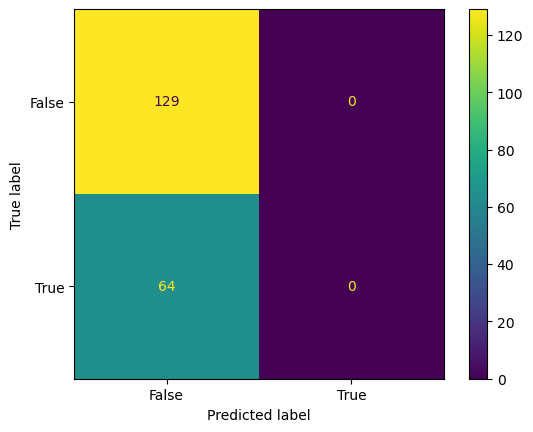

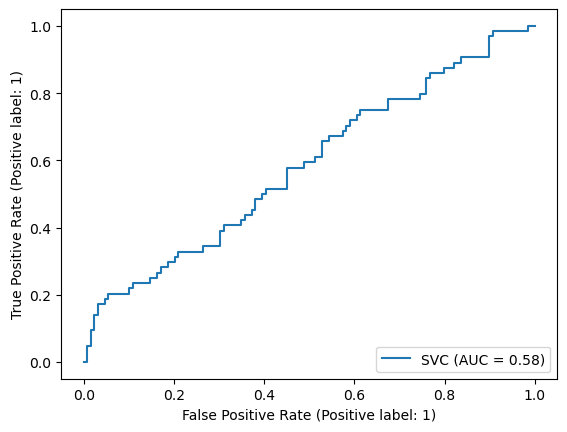

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.668394        0.0                 0.0          1.0  0.583212


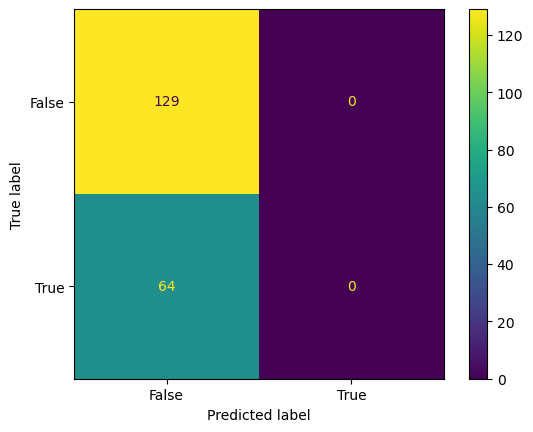

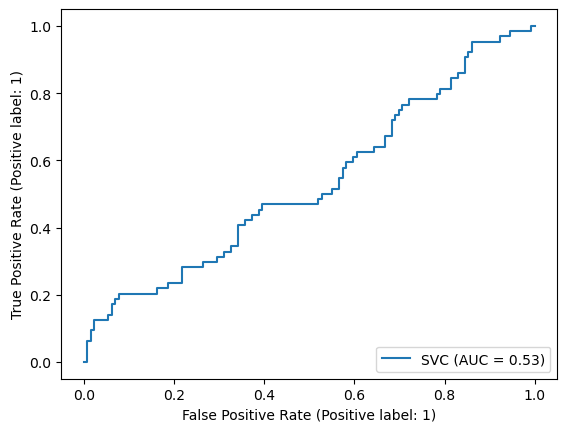

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.668394        0.0                 0.0          1.0  0.583212
1  0.668394        0.0                 0.0          1.0  0.531250


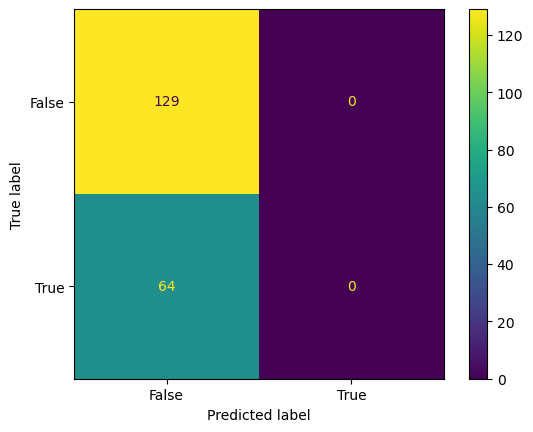

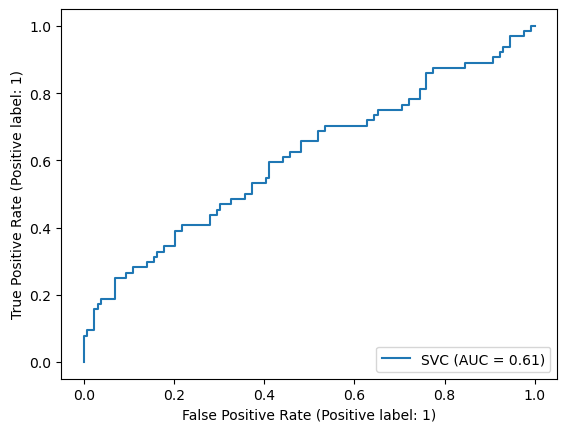

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.668394        0.0                 0.0          1.0  0.583212
1  0.668394        0.0                 0.0          1.0  0.531250
2  0.668394        0.0                 0.0          1.0  0.607558


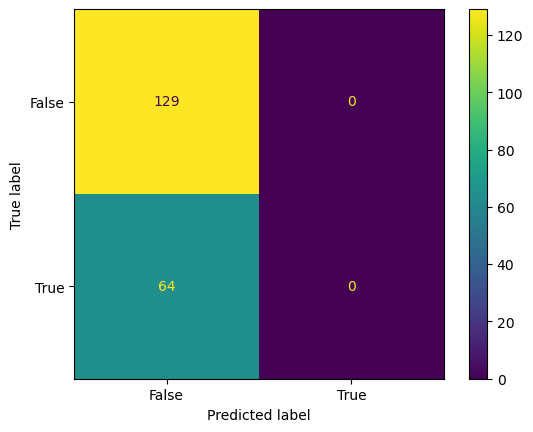

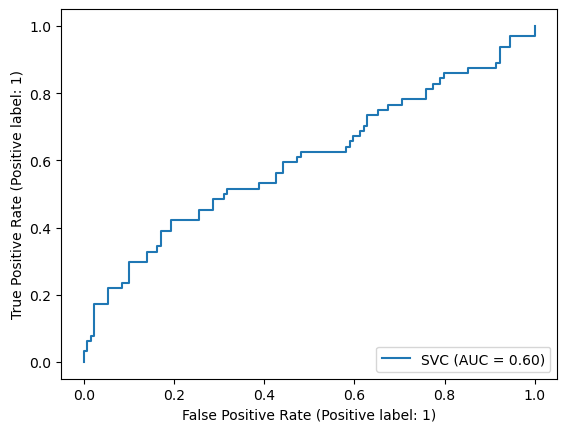

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.668394        0.0                 0.0          1.0  0.583212
1  0.668394        0.0                 0.0          1.0  0.531250
2  0.668394        0.0                 0.0          1.0  0.607558
3  0.668394        0.0                 0.0          1.0  0.600775


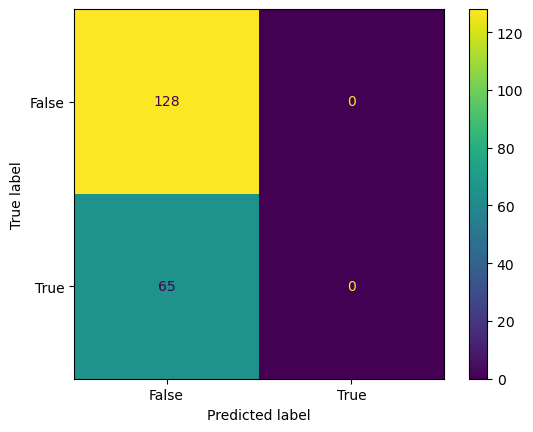

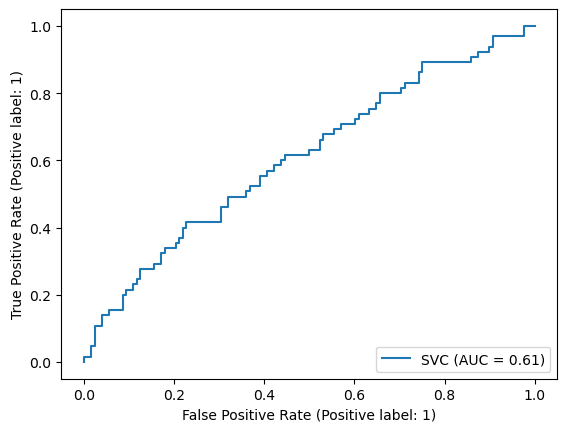

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.668394        0.0                 0.0          1.0  0.583212
1  0.668394        0.0                 0.0          1.0  0.531250
2  0.668394        0.0                 0.0          1.0  0.607558
3  0.668394        0.0                 0.0          1.0  0.600775
4  0.663212        0.0                 0.0          1.0  0.608894


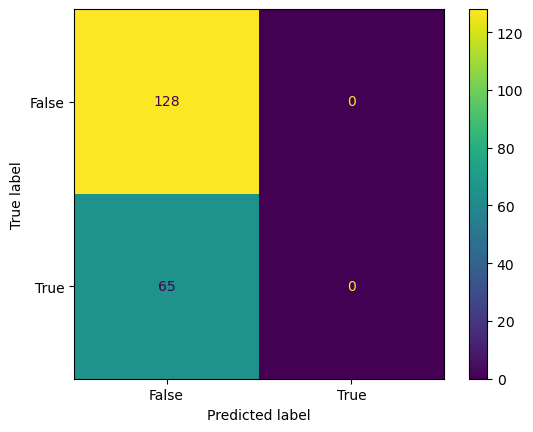

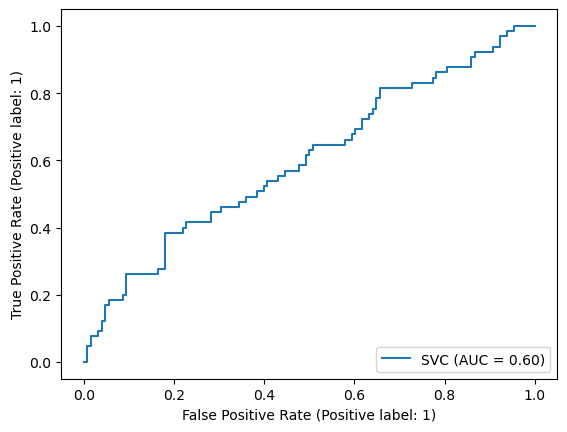

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.668394        0.0                 0.0          1.0  0.583212
1  0.668394        0.0                 0.0          1.0  0.531250
2  0.668394        0.0                 0.0          1.0  0.607558
3  0.668394        0.0                 0.0          1.0  0.600775
4  0.663212        0.0                 0.0          1.0  0.608894
5  0.663212        0.0                 0.0          1.0  0.600120


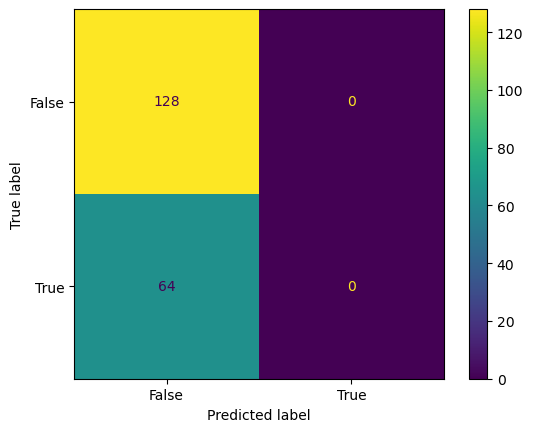

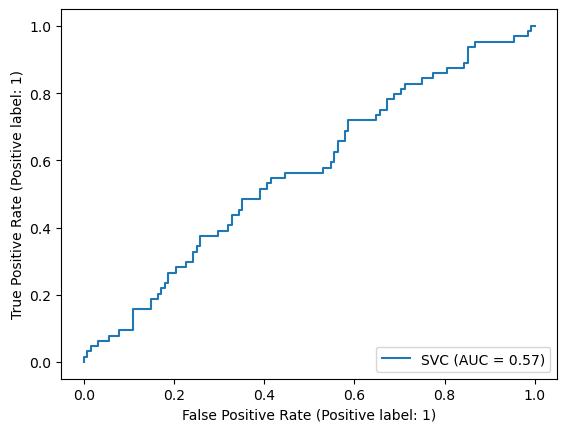

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.668394        0.0                 0.0          1.0  0.583212
1  0.668394        0.0                 0.0          1.0  0.531250
2  0.668394        0.0                 0.0          1.0  0.607558
3  0.668394        0.0                 0.0          1.0  0.600775
4  0.663212        0.0                 0.0          1.0  0.608894
5  0.663212        0.0                 0.0          1.0  0.600120
6  0.666667        0.0                 0.0          1.0  0.566040


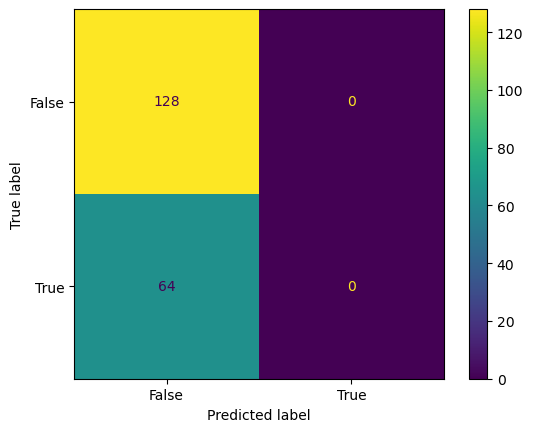

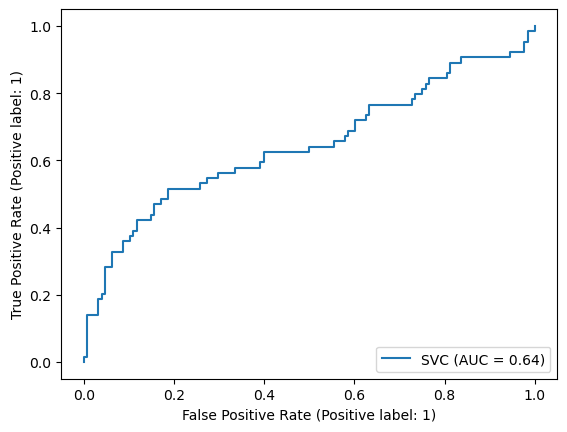

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.668394        0.0                 0.0          1.0  0.583212
1  0.668394        0.0                 0.0          1.0  0.531250
2  0.668394        0.0                 0.0          1.0  0.607558
3  0.668394        0.0                 0.0          1.0  0.600775
4  0.663212        0.0                 0.0          1.0  0.608894
5  0.663212        0.0                 0.0          1.0  0.600120
6  0.666667        0.0                 0.0          1.0  0.566040
7  0.666667        0.0                 0.0          1.0  0.644165


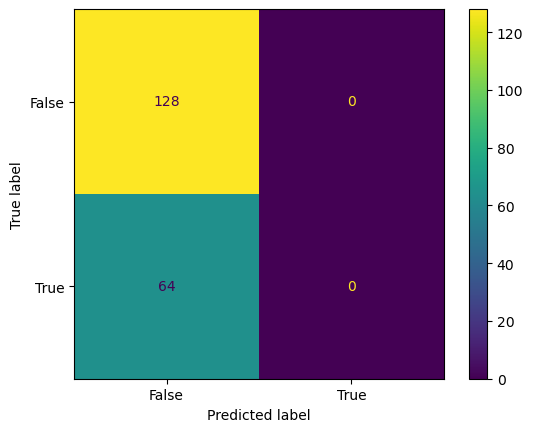

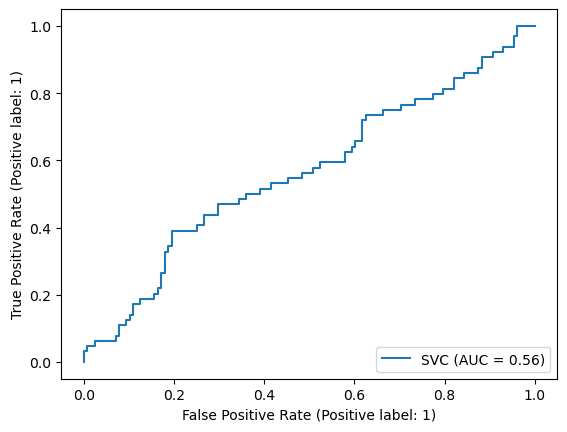

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.668394        0.0                 0.0          1.0  0.583212
1  0.668394        0.0                 0.0          1.0  0.531250
2  0.668394        0.0                 0.0          1.0  0.607558
3  0.668394        0.0                 0.0          1.0  0.600775
4  0.663212        0.0                 0.0          1.0  0.608894
5  0.663212        0.0                 0.0          1.0  0.600120
6  0.666667        0.0                 0.0          1.0  0.566040
7  0.666667        0.0                 0.0          1.0  0.644165
8  0.666667        0.0                 0.0          1.0  0.564331


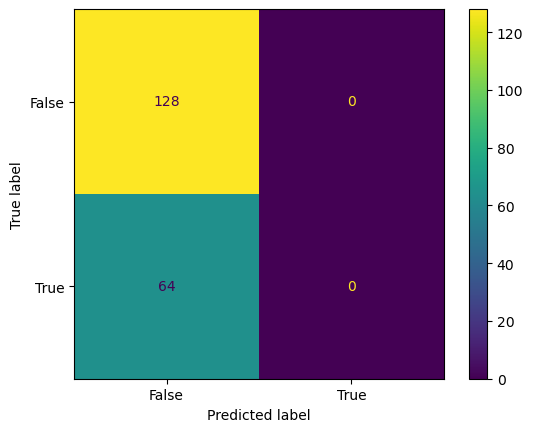

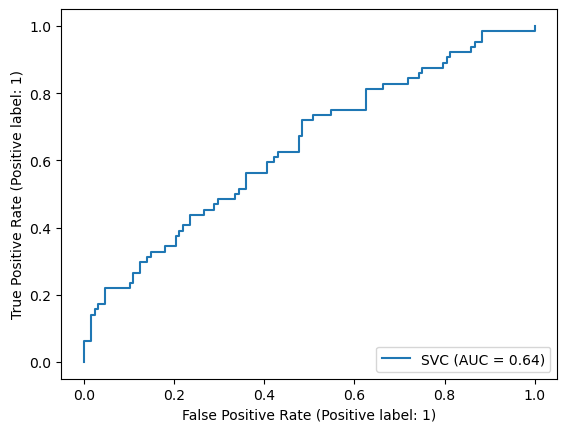

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.668394        0.0                 0.0          1.0  0.583212
1  0.668394        0.0                 0.0          1.0  0.531250
2  0.668394        0.0                 0.0          1.0  0.607558
3  0.668394        0.0                 0.0          1.0  0.600775
4  0.663212        0.0                 0.0          1.0  0.608894
5  0.663212        0.0                 0.0          1.0  0.600120
6  0.666667        0.0                 0.0          1.0  0.566040
7  0.666667        0.0                 0.0          1.0  0.644165
8  0.666667        0.0                 0.0          1.0  0.564331
9  0.666667        0.0                 0.0          1.0  0.638916


In [34]:
# Inisialisasi objek stratified k-fold dengan inisial skf
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Melakukan scaling pada data
scaler = StandardScaler()

results=[]

# Inisialisasi objek SVM
pipe = SVC(kernel='rbf',  C=0.1, gamma='auto', probability=True)
# pipe = SVC(kernel='poly',  C=1.0, gamma='scale', probability=True)
# pipe = SVC(kernel='linear',  C=1.0, gamma='scale', probability=True)
# pipe = SVC(kernel='sigmoid',  C=1.0, gamma='scale', probability=True)

# Loop untuk setiap fold
for train_index, test_index in skf.split(X, y):
    
    # Memisahkan data untuk training dan testing
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Melakukan training pada model SVM
    pipe.fit(X_train, y_train)
    
    # Melakukan prediksi pada data testing
    y_pred = pipe.predict(X_test)
    
    # Hitung Probabilitas
    y_prob = pipe.decision_function(X_test)
    
    # Confusion Matrix
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
     
    Accuracy = metrics.accuracy_score(y_test, y_pred)
    Precision = metrics.precision_score(y_test, y_pred)
    Sensitivity_recall = metrics.recall_score(y_test, y_pred)
    Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
    
#     print(classification_report(y_test, y_pred))
    plot_roc_curve(pipe, X_test, y_test)
    plt.show()
    
    # AUC (y_prob[:,1] khusus untuk random forest dan knn)
    auc = roc_auc_score(y_test, y_prob)
    
     # Simpan hasil ke dalam list
    results.append({'Accuracy': Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity, 'AUC':auc})
    
    # Buat dataframe dari hasil
    df = pd.DataFrame(results)

    # Print dataframe
    print(df)


# Evaluasi model menggunakan *Confusion Matrix* dan *AUC*

In [ ]:
#     # Confusion Matrix
#     confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

#     cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

#     cm_display.plot()
#     plt.show()
     
#     Accuracy = metrics.accuracy_score(y_test, y_pred)
#     Precision = metrics.precision_score(y_test, y_pred)
#     Sensitivity_recall = metrics.recall_score(y_test, y_pred)
#     Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
#     print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity})
    
# #     print(classification_report(y_test, y_pred))
#     plot_roc_curve(pipe, X_test, y_test)
#     plt.show()
    
#     # AUC (y_prob[:,1] khusus untuk random forest dan knn)
#     auc = roc_auc_score(y_test, y_prob)
#     print('AUC:', auc)

# Klasifikasi menggunakan *Random Forest* (Opsional)

In [ ]:
# # inisialisasi model Random Forest
# rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# # cross-validation dengan StratifiedKFold 10
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # inisialisasi scalar
# sc = StandardScaler()

# # inisialisasi pipeline dengan random forest dan scalar
# pipe = make_pipeline(sc, rfc)

# # inisialisasi list untuk menampung hasil skor dari setiap fold
# scores = []
# results = []

# # loop untuk setiap fold
# for train_index, test_index in cv.split(X, y):
#     X_train, X_test = X.values[train_index], X.values[test_index]
#     y_train, y_test = y.values[train_index], y.values[test_index]
    
#     # training model
#     pipe.fit(X_train, y_train)
    
#     # scoring model
#     score = pipe.score(X_test, y_test)
#     scores.append(score)

#     # Melakukan prediksi pada data testing
#     y_pred = pipe.predict(X_test)
    
#     # Hitung Probabilitas
#     y_prob =pipe.predict_proba(X_test)

#     # Confusion Matrix
#     confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

#     cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

#     cm_display.plot()
#     plt.show()
     
#     Accuracy = metrics.accuracy_score(y_test, y_pred)
#     Precision = metrics.precision_score(y_test, y_pred)
#     Sensitivity_recall = metrics.recall_score(y_test, y_pred)
#     Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
    
# #     print(classification_report(y_test, y_pred))
#     plot_roc_curve(pipe, X_test, y_test)
#     plt.show()
    
#     # AUC (y_prob[:,1] khusus untuk random forest dan knn)
#     auc = roc_auc_score(y_test, y_prob[:,1])
    
#      # Simpan hasil ke dalam list
#     results.append({'Accuracy': Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity, 'AUC':auc})
    
#     # Buat dataframe dari hasil
#     df = pd.DataFrame(results)

#     # Print dataframe
#     print(df)

# Klasifikasi menggunakan *K-Nearest Neighbor* (Opsional)

In [ ]:
# # inisialisasi model KNN
# knn = KNeighborsClassifier(n_neighbors=7)

# # cross-validation dengan StratifiedKFold 10
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # inisialisasi scalar
# sc = StandardScaler()

# # inisialisasi pipeline dengan KNN dan scalar
# pipe = make_pipeline(sc, knn)

# # inisialisasi list untuk menampung hasil skor dari setiap fold
# scores = []

# # loop untuk setiap fold
# for train_index, test_index in cv.split(X, y):
#     X_train, X_test = X.values[train_index], X.values[test_index]
#     y_train, y_test = y.values[train_index], y.values[test_index]
    
#     # training model
#     pipe.fit(X_train, y_train)
    
#     # scoring model
#     score = pipe.score(X_test, y_test)
#     scores.append(score)

#     # Melakukan prediksi pada data testing
#     y_pred = pipe.predict(X_test)
    
#     # Hitung Probabilitas
#     y_prob =pipe.predict_proba(X_test)

# Klasifikasi menggunakan *Decision Tree* (Opsional)

In [ ]:
# # inisialisasi model Decision Tree
# dtc = DecisionTreeClassifier(random_state=42)

# # cross-validation dengan StratifiedKFold 10
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # inisialisasi scalar
# sc = StandardScaler()

# # inisialisasi pipeline dengan decision tree dan scalar
# pipe = make_pipeline(sc, dtc)

# # training model dengan cross-validation
# scores = cross_val_score(pipe, X, y, cv=cv)

# y_pred = cross_val_predict(pipe, X, y, cv=cv)